In [ ]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.banana2d import Banana2D
from mcjax.mcmc.mala import Mala
from mcjax.util.plot_2d import evaluate_on_grid_2d


In [2]:
# initialize jax RNG
key = jr.key(0)

### 2D Banana

In [3]:
# create an isotropic Gaussian
dist = Banana2D(noise_std = 0.3)
logdensity = dist.logdensity
logdensity_batch = jax.vmap(logdensity)

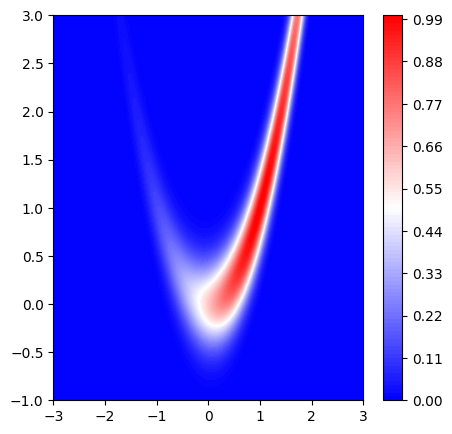

In [4]:
xmin, xmax = -3, 3
ymin, ymax = -1, 3
X, Y, Z = evaluate_on_grid_2d(
    func_batch=logdensity_batch,
    xlim=(xmin, xmax),
    ylim=(ymin, ymax),
    Nx=500,
    Ny=500
)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.colorbar()
plt.show()


## Run Mala

In [5]:
mcmc = Mala(logdensity=logdensity, step_size=0.01)

In [6]:
key, key_ = jr.split(key)
x_init = jnp.array([0., 0.])
state_init = mcmc.init_state(x_init)
mcmc_output = mcmc.run(key = key_, n_samples=10_000, state_init=state_init)
traj = mcmc_output.traj 
summary = mcmc_output.summary

(-1.0, 3.0)

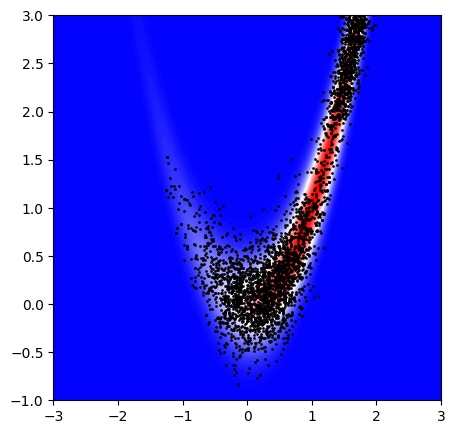

In [7]:
samples = traj.x
# scatter plot of the samples
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.scatter(samples[:, 0], samples[:, 1], s=1, color='black', alpha=0.9)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

In [8]:
acceptance_rate = summary.acceptance_rate
print(f"Acceptance rate: {100*acceptance_rate:.2f}%")

Acceptance rate: 57.11%


## Influence of epsilon on the acceptance rate

In [9]:
# let's define a function that samples a trajectory -- small wrapper around the `sample_RWM` function
def sample_MALA(key, x0, epsilon, n_steps):
    # define the RWM sampler
    mcmc = Mala(logdensity=logdensity, step_size=epsilon)
    # sample the trajectory
    state_init = mcmc.init_state(x0)
    mcmc_output = mcmc.run(key = key, n_samples=n_steps, state_init=state_init)
    return mcmc_output

sample_MALA = jax.jit(sample_MALA, static_argnums=(3,))

# let's define a function that samples a batch of trajectories
# for different step sizes so that we can study the influence of the step size
sample_MALA_batch = jax.vmap(sample_MALA, in_axes=(None, None, 0, None))
sample_MALA_batch = jax.jit(sample_MALA_batch, static_argnums=(3,))

In [13]:
epsilon_arr = 10**np.linspace(-3, 0, 200)
n_steps = 200_000
key, key_ = jr.split(key)
x0 = jnp.array([0., 0.])
mcmc_output_batch = sample_MALA_batch(key_, x0, epsilon_arr, n_steps)
traj_batch = mcmc_output_batch.traj
summary_batch = mcmc_output_batch.summary

Text(0.6, 0.6, 'Optimal step size: 0.10 \n Acceptance rate: 0.27')

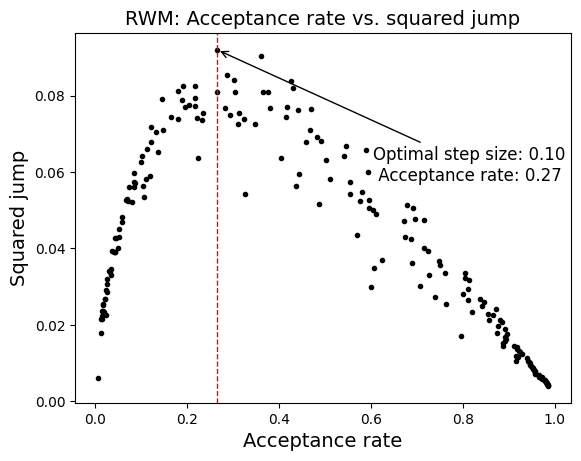

In [14]:
plt.plot(summary_batch.acceptance_rate, summary_batch.sq_jump, ".", color='black')
plt.xlabel("Acceptance rate", fontsize=14)
plt.ylabel("Squared jump", fontsize=14)
plt.title("RWM: Acceptance rate vs. squared jump", fontsize=14)

# find the optimal step size by maximizing the squared jump
index_opt = np.argmax(summary_batch.sq_jump)
optimal_step_size = epsilon_arr[index_opt]
optimal_acceptance_rate = summary_batch.acceptance_rate[index_opt]
optimal_sq_jump = summary_batch.sq_jump[index_opt]

# draw vertical line at the optimal step size
plt.axvline(optimal_acceptance_rate, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal step size: {optimal_step_size:.2f} \n Acceptance rate: {optimal_acceptance_rate:.2f}",
                xy=(optimal_acceptance_rate, optimal_sq_jump),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)